In [190]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score, 
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


data = pd.read_csv("/Users/ww/coe379L-sp25/datasets/unit01/project1.csv")

# Display data informations
print("Dataset Shape:", data.shape)
print("\nFirst 5 Rows:")
print(data.head())

print("\nDataset Info:")
print(data.info())


print("\nMissing Value Summary:")
print(data.isnull().sum())




Dataset Shape: (386, 10)

First 5 Rows:
                  class    age menopause tumor-size inv-nodes node-caps  \
0     recurrence-events  30-39   premeno      30-34       0-2        no   
1  no-recurrence-events  40-49   premeno      20-24       0-2        no   
2     recurrence-events  40-49   premeno      20-24       0-2        no   
3  no-recurrence-events  60-69      ge40      15-19       0-2        no   
4  no-recurrence-events  40-49   premeno        0-4       0-2        no   

   deg-malig breast breast-quad irradiat  
0          3   left    left_low       no  
1          2  right    right_up       no  
2          2   left    left_low       no  
3          2  right     left_up       no  
4          2  right   right_low       no  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        386 non-null    object
 1   age

In [191]:
# Define possible missing value indicators
missing_values = ['?', '*', 'NA', 'N/A', 'nan', 'NaN', '-', 'unknown', 'missing']

for col in data.columns:
    # Replace special characters with NaN
    data[col] = data[col].replace(missing_values, np.nan)
    
    # Check the number of missing values
    missing_count = data[col].isnull().sum()
    if missing_count > 0:
        print(f"Column '{col}' has {missing_count} missing values.")
        
        # Fill missing values with the mode
        mode_val = data[col].mode()[0]
        data[col] = data[col].fillna(mode_val)
        print(f"  - Filled with mode value: '{mode_val}'.")


Column 'tumor-size' has 1 missing values.
  - Filled with mode value: '30-34'.
Column 'inv-nodes' has 1 missing values.
  - Filled with mode value: '0-2'.
Column 'node-caps' has 12 missing values.
  - Filled with mode value: 'no'.
Column 'breast-quad' has 6 missing values.
  - Filled with mode value: 'left_low'.


In [192]:
# Check and Remove Duplicate Rows
duplicates = data.duplicated().sum()
if duplicates > 0:
    print(f"Found {duplicates} duplicate rows")
    data = data.drop_duplicates()
    print(f"Dataset shape after removal: {data.shape}")


Found 13 duplicate rows
Dataset shape after removal: (373, 10)


In [193]:
#Convert variable
data['class'] = data['class'].map({'recurrence-events': 1, 'no-recurrence-events': 0})
print("Target variable has been converted: recurrence-events = 1, no-recurrence-events = 0")

# Convert categorical variables
binary_features = {
    'node-caps': {'yes': 1, 'no': 0},
    'breast': {'left': 0, 'right': 1},
    'irradiat': {'yes': 1, 'no': 0}
}

for col, mapping in binary_features.items():
    data[col] = data[col].map(mapping)
    print(f"Column '{col}' has been converted to binary features.")

# Handle categorical variables
age_mapping = {
    '20-29': 2, '30-39': 3, '40-49': 4, 
    '50-59': 5, '60-69': 6, '70-79': 7,
    '80-89': 8, '90-99': 9
}

tumor_size_mapping = {
    '0-4': 1, '5-9': 2, '10-14': 3, '15-19': 4, 
    '20-24': 5, '25-29': 6, '30-34': 7, '35-39': 8, 
    '40-44': 9, '45-49': 10, '50-54': 11, '55-59': 12
}

inv_nodes_mapping = {
    '0-2': 1, '3-5': 2, '6-8': 3, '9-11': 4, 
    '12-14': 5, '15-17': 6, '18-20': 7, '21-23': 8, 
    '24-26': 9, '27-29': 10, '30-32': 11, '33-35': 12, 
    '36-39': 13
}

# Apply mapping
data['age'] = data['age'].map(age_mapping)
data['tumor-size'] = data['tumor-size'].map(tumor_size_mapping)
data['inv-nodes'] = data['inv-nodes'].map(inv_nodes_mapping)

# Check if mapping resulted in missing values
for col in ['age', 'tumor-size', 'inv-nodes']:
    missing = data[col].isnull().sum()
    if missing > 0:
        print(f"Column '{col}' has {missing} missing values (possibly due to incomplete mapping).")
        # Fill with the median
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)
        print(f"  - Filled with median value: {median_val}")

# One-Hot Encoding
categorical_features = ['menopause', 'breast-quad']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)
print(f"One-hot encoding applied to: {categorical_features}")

# Check
print("\nFinal dataset shape:", data.shape)
print("\nData types:")
print(data.dtypes)
print("\nMissing value check:")
print(data.isnull().sum())
print("\nPreview of processed data:")
print(data.head())


Target variable has been converted: recurrence-events = 1, no-recurrence-events = 0
Column 'node-caps' has been converted to binary features.
Column 'breast' has been converted to binary features.
Column 'irradiat' has been converted to binary features.
One-hot encoding applied to: ['menopause', 'breast-quad']

Final dataset shape: (373, 14)

Data types:
class                    int64
age                      int64
tumor-size               int64
inv-nodes                int64
node-caps                int64
deg-malig                int64
breast                   int64
irradiat                 int64
menopause_lt40           uint8
menopause_premeno        uint8
breast-quad_left_low     uint8
breast-quad_left_up      uint8
breast-quad_right_low    uint8
breast-quad_right_up     uint8
dtype: object

Missing value check:
class                    0
age                      0
tumor-size               0
inv-nodes                0
node-caps                0
deg-malig                0
breast     

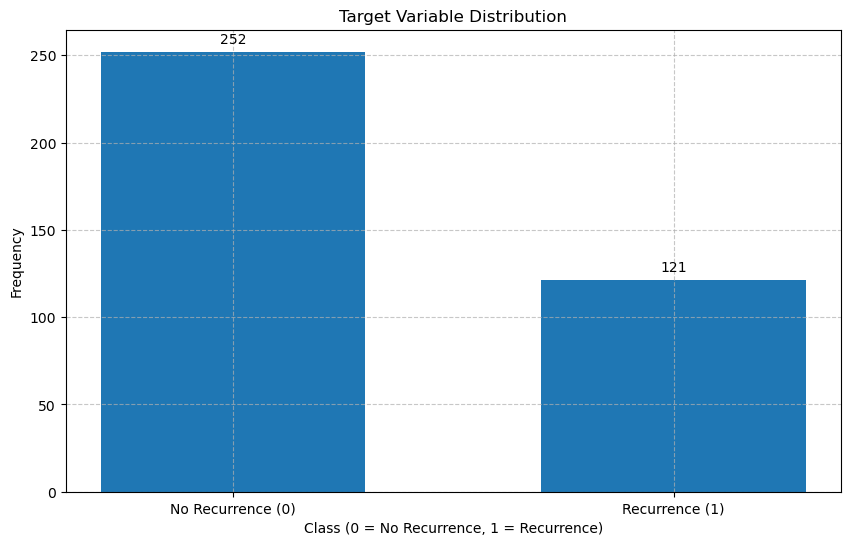

In [194]:
plt.figure(figsize=(10, 6))

# Plot histogram
counts = data['class'].value_counts().sort_index()
bars = plt.bar([0, 1], counts.values, width=0.6)

# Add title and labels
plt.title('Target Variable Distribution')
plt.xlabel('Class (0 = No Recurrence, 1 = Recurrence)')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No Recurrence (0)', 'Recurrence (1)'])

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, 
             str(counts.values[i]), ha='center')

plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('class_histogram_fixed.png')
plt.show()


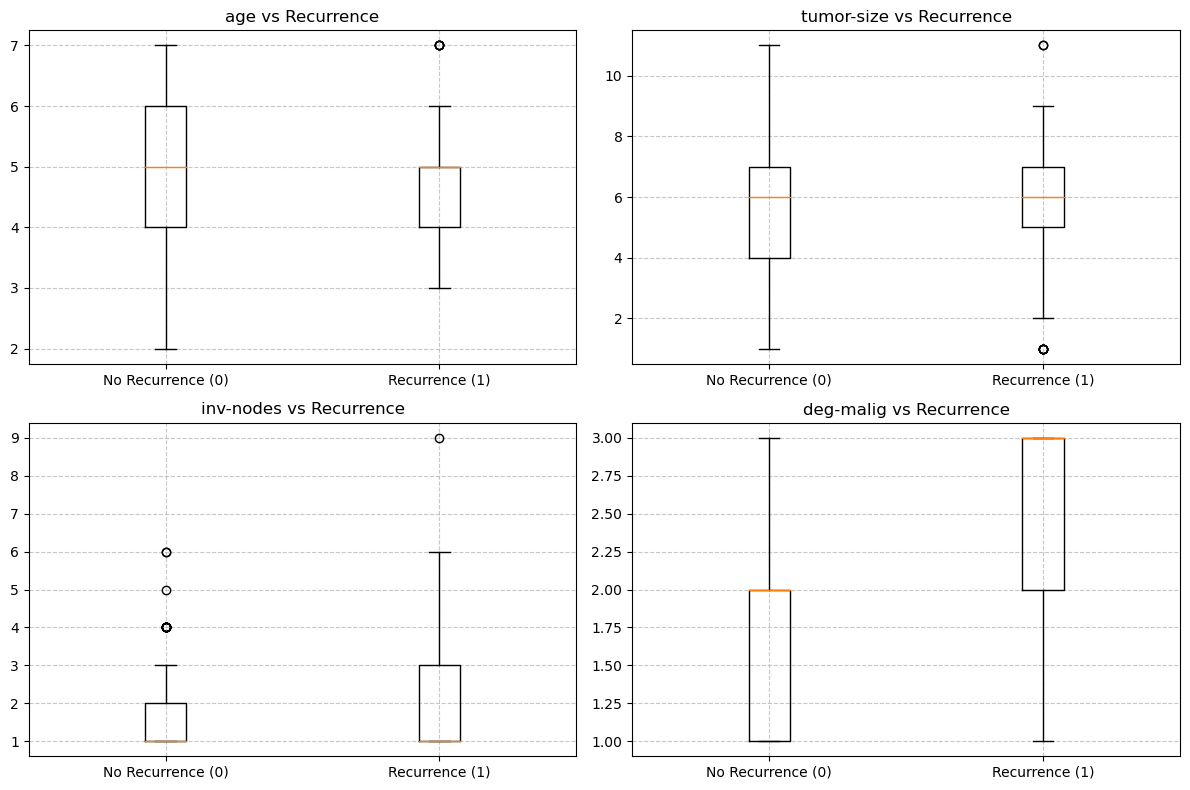

In [195]:
# Create box plot
plt.figure(figsize=(12, 8))

numeric_features = ['age', 'tumor-size', 'inv-nodes', 'deg-malig']


for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    
    data_0 = data[data['class'] == 0][feature]
    data_1 = data[data['class'] == 1][feature]
    
    plt.boxplot([data_0, data_1], labels=['No Recurrence (0)', 'Recurrence (1)'])
    plt.title(f'{feature} vs Recurrence')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

plt.show()


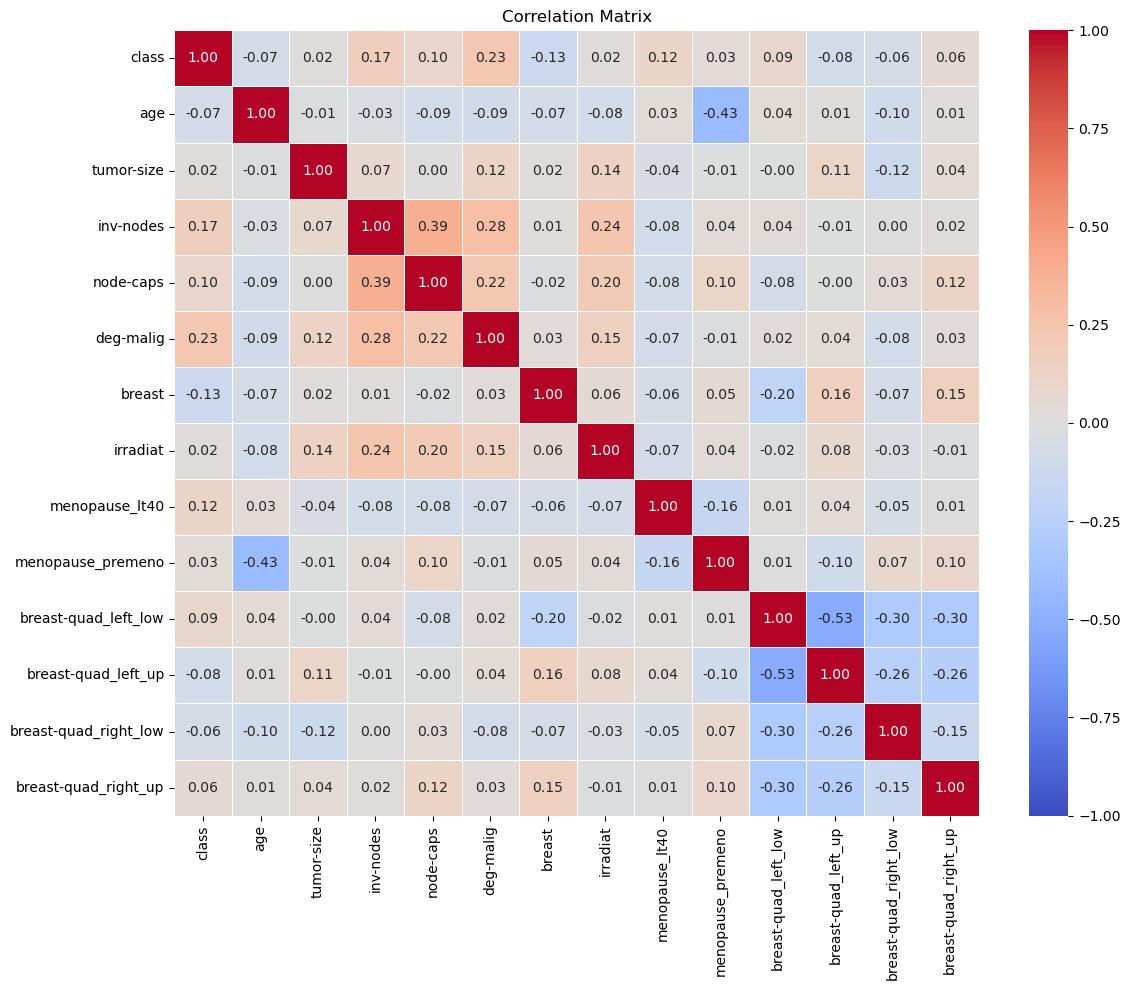

In [196]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1)

# Add title
plt.title('Correlation Matrix')
plt.tight_layout()

plt.show()


In [197]:
# Check the distribution of the target variable
print("Original class distribution:")
print(data['class'].value_counts())
print(f"Class 0: {data['class'].value_counts()[0] / len(data):.2%}")
print(f"Class 1: {data['class'].value_counts()[1] / len(data):.2%}")

# Separate features and target variable
X = data.drop('class', axis=1) 
y = data['class']              

# Split the data using stratified sampling
# maintains the same class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the sizes of the split datasets
print("\nData split sizes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Verify that stratified sampling was effective
train_class_dist = y_train.value_counts(normalize=True) * 100
test_class_dist = y_test.value_counts(normalize=True) * 100

print("\nTraining set class distribution:")
print(train_class_dist.to_string())

print("\nTest set class distribution:")
print(test_class_dist.to_string())



Original class distribution:
0    252
1    121
Name: class, dtype: int64
Class 0: 67.56%
Class 1: 32.44%

Data split sizes:
X_train shape: (298, 13)
X_test shape: (75, 13)
y_train shape: (298,)
y_test shape: (75,)

Training set class distribution:
0    67.449664
1    32.550336

Test set class distribution:
0    68.0
1    32.0


/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ww/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best cross-validation score: 0.4030

Model Performance Comparison:
                  Model  Accuracy    Recall  Precision  F1 Score
0                  KNN  0.613333  0.208333   0.333333  0.256410
1        Optimized KNN  0.586667  0.333333   0.347826  0.340426
2  Logistic Regression  0.613333  0.166667   0.307692  0.216216

Detailed Classification Reports:

KNN:
               precision    recall  f1-score   support

           0       0.68      0.80      0.74        51
           1       0.33      0.21      0.26        24

    accuracy                           0.61        75
   macro avg       0.51      0.51      0.50        75
weighted avg       0.57      0.61      0.58        75


Optimized KNN:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70        51
           1       0.35      0.33      0.34        24

    accuracy                           0.5

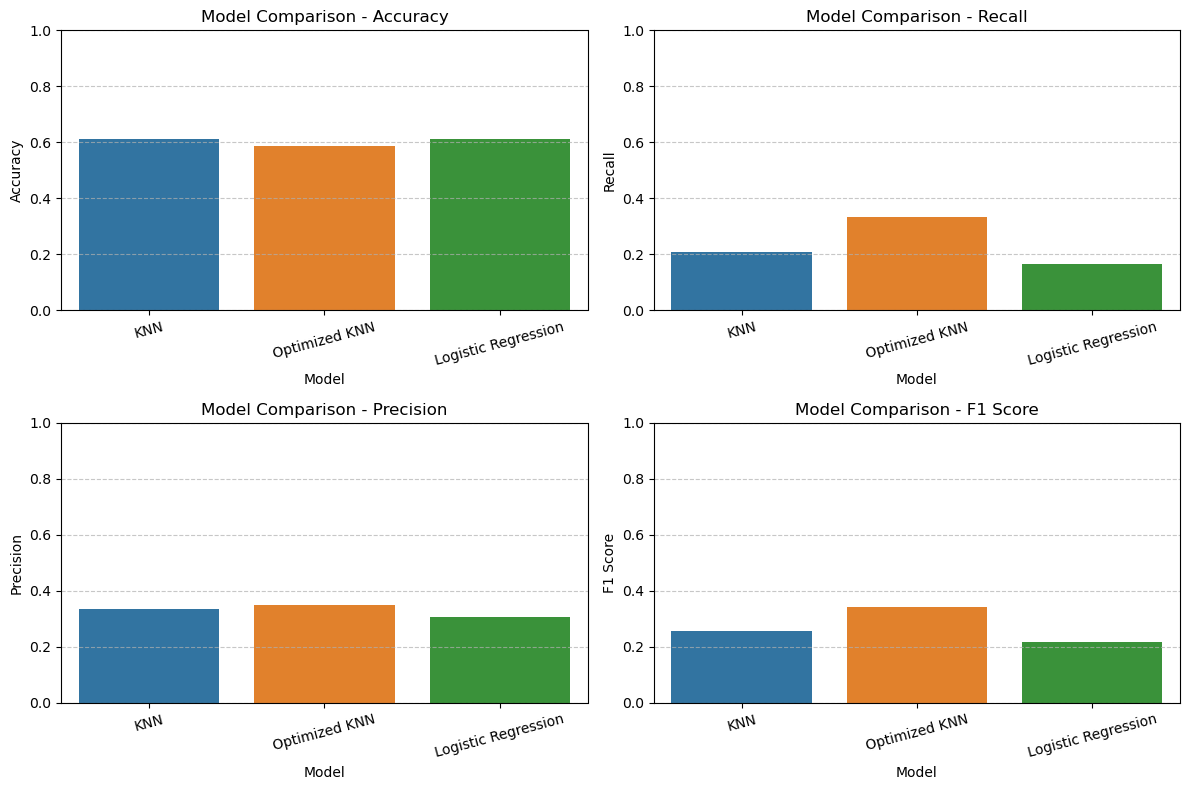

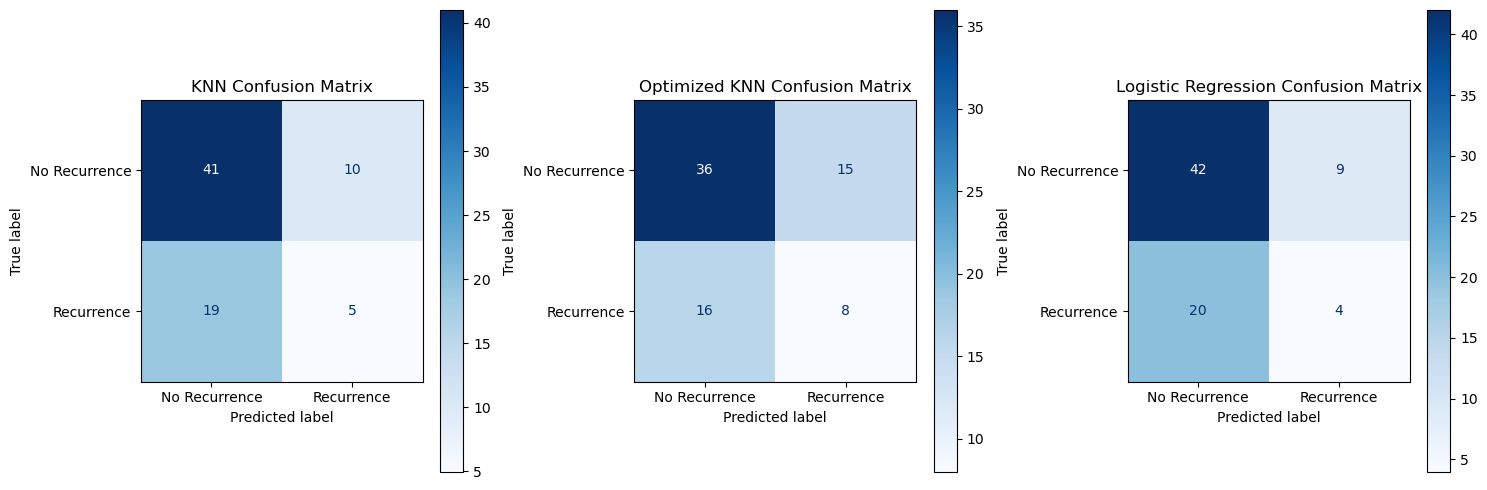

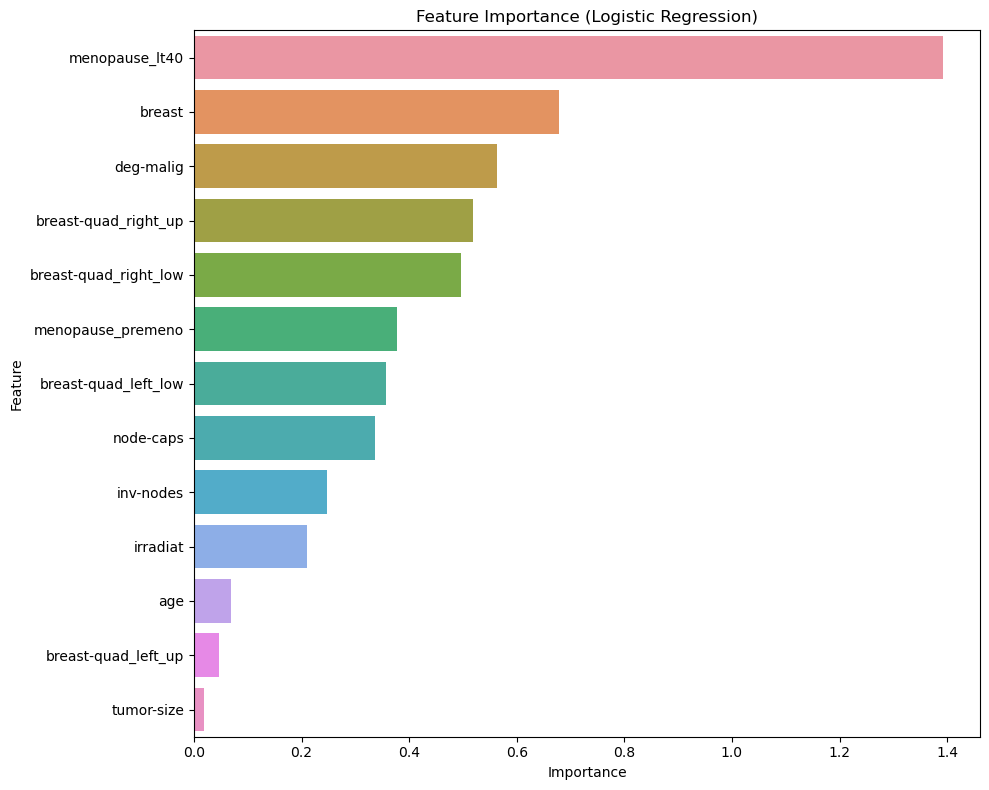

In [198]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#Train KNN Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

#Optimize KNN with Grid Search CV
param_grid = {
    'n_neighbors': range(1, 31),  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5, 
    scoring='f1',  
    n_jobs=-1  
)
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
y_pred_best_knn = best_knn.predict(X_test)

print(f"Best KNN parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

#Train Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

#Evaluate Model Performance
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and return model performance metrics."""
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

#Collect results for each model
results = [
    evaluate_model(y_test, y_pred_knn, 'KNN'),
    evaluate_model(y_test, y_pred_best_knn, 'Optimized KNN'),
    evaluate_model(y_test, y_pred_logreg, 'Logistic Regression')
]

#Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n", results_df)

#Display Classification Reports
print("\nDetailed Classification Reports:")
for name, pred in zip(["KNN", "Optimized KNN", "Logistic Regression"], 
                       [y_pred_knn, y_pred_best_knn, y_pred_logreg]):
    print(f"\n{name}:\n", classification_report(y_test, pred))

#Visualize
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x=results_df['Model'], y=results_df[metric])  # 修正数据格式问题
    plt.title(f'Model Comparison - {metric}')
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()


#Plot Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, y_pred) in zip(axes, models):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['No Recurrence', 'Recurrence'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{name} Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

#Feature Importance
plt.figure(figsize=(10, 8))
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(logreg.coef_[0])
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Logistic Regression)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

